In [1]:
import numpy as np
from glob import glob
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Softmax
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

A simple CNN model structure

```
model = Sequential()
# first layer
model.add(Conv2D())             # feature selection/processing
model.add(MaxPooling2D())       # downsampling
model.add(BatchNormalization()) # rescaling/normalize
model.add(Dropout(0.3))         # Drop noisy data

# Second layer
model.add(Conv2D())             # feature selection/processing
model.add(MaxPooling2D())       # downsampling
model.add(BatchNormalization()) # rescaling/normalize
model.add(Dropout(0.3))         # Drop noisy data

and so on ...
```

In [2]:
img_size = [224,224]
test_path = "../input/cars-dataset/Test"
train_path = "../input/cars-dataset/Train"

In [3]:
[224,224]+[3]

[224, 224, 3]

94765736/94765736 [==============================] - 0s 0us/step


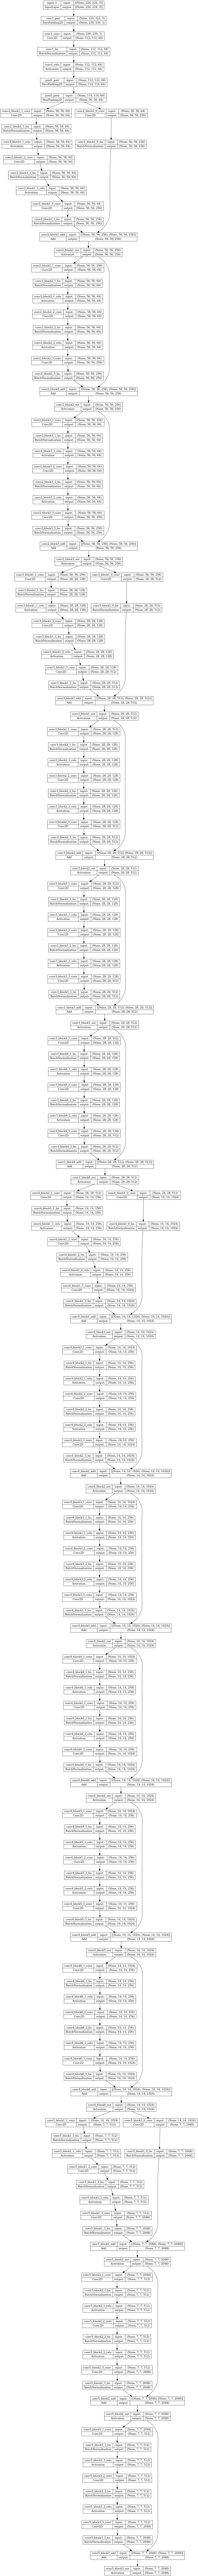

In [4]:
resnet = ResNet50(include_top=False,
                  input_shape=img_size+[3],   # Making the image into 3 Channel, so concating 3.
                  weights="imagenet")
# visualize the layers
plot_model(resnet, show_shapes=True, show_layer_names=True)

In [5]:
# Parameter informations
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [6]:
# False for pretrained model, use the default weights used by the imagenet.   
for layer in resnet.layers:
    layer.trainable = False

In [7]:
folders = glob("../input/cars-dataset/Train/*")
folders

['../input/cars-dataset/Train/mercedes',
 '../input/cars-dataset/Train/lamborghini',
 '../input/cars-dataset/Train/audi']

In [8]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc')
]

In [9]:
# convert model output to single dimension
x= Flatten()(resnet.output)

prediction = Dense(len(folders),activation="softmax")(x)
model = Model(inputs= resnet.input, outputs=prediction)
plot_model(model)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=METRICS)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# creating Dynamic image augmentation
train_datagen = ImageDataGenerator(rescale=1/255,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  rotation_range=5,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1/255)

In [12]:
training_set = train_datagen.flow_from_directory("../input/cars-dataset/Train",target_size=(224,224),batch_size=32,class_mode="categorical")
testing_set = test_datagen.flow_from_directory("../input/cars-dataset/Test",target_size=(224,224),batch_size=32,class_mode="categorical")

Found 64 images belonging to 3 classes.
Found 58 images belonging to 3 classes.


In [13]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(verbose=1, patience=20)
r = model.fit(training_set,
          validation_data=testing_set,
          epochs=50,
          steps_per_epoch=len(training_set),
          validation_steps=len(testing_set),
          callbacks=[es])
r

Epoch 1/50
2/2 [==============================] - 12s 2s/step - loss: 4.1173 - accuracy: 0.5521 - precision: 0.2381 - recall: 0.1562 - auc: 0.4916 - val_loss: 15.4049 - val_accuracy: 0.5517 - val_precision: 0.3276 - val_recall: 0.3276 - val_auc: 0.4957
Epoch 2/50
2/2 [==============================] - 1s 655ms/step - loss: 9.7015 - accuracy: 0.5938 - precision: 0.3906 - recall: 0.3906 - auc: 0.5430 - val_loss: 1.2768 - val_accuracy: 0.5747 - val_precision: 0.3261 - val_recall: 0.2586 - val_auc: 0.5364
Epoch 3/50
2/2 [==============================] - 1s 619ms/step - loss: 3.6408 - accuracy: 0.6250 - precision: 0.4259 - recall: 0.3594 - auc: 0.5708 - val_loss: 5.8162 - val_accuracy: 0.6897 - val_precision: 0.5345 - val_recall: 0.5345 - val_auc: 0.6310
Epoch 4/50
2/2 [==============================] - 1s 642ms/step - loss: 8.5139 - accuracy: 0.5104 - precision: 0.2656 - recall: 0.2656 - auc: 0.4001 - val_loss: 8.1716 - val_accuracy: 0.4368 - val_precision: 0.1552 - val_recall: 0.1552 - v

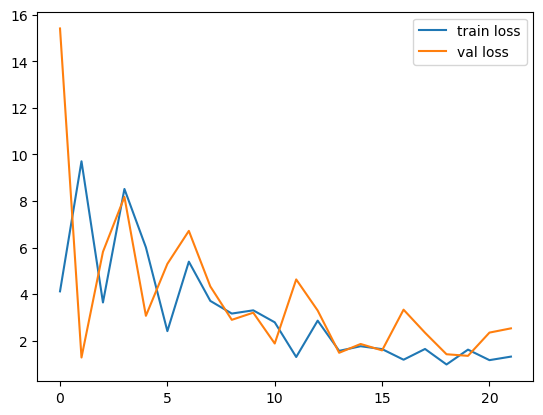

<Figure size 640x480 with 0 Axes>

In [14]:
plt.plot(r.history['loss'],label='train loss')
plt.plot(r.history['val_loss'],label='val loss')
plt.legend()
plt.show()
plt.savefig("LossVal_loss")

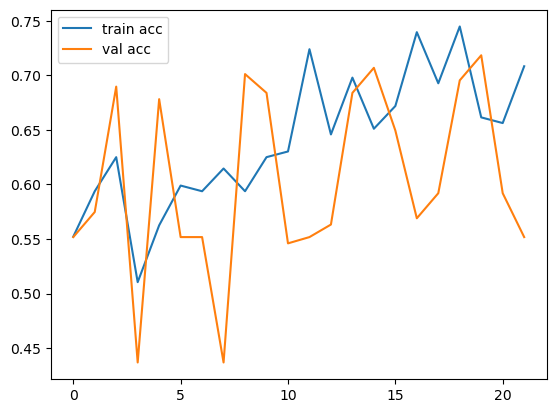

<Figure size 640x480 with 0 Axes>

In [15]:
plt.plot(r.history['accuracy'],label='train acc')
plt.plot(r.history['val_accuracy'],label='val acc')
plt.legend()
plt.show()
plt.savefig("AccuVal_acc")

In [16]:
model.save('../working/model_resent50.h5')
y_pred = model.predict(testing_set)
print(y_pred)

2/2 [==============================] - 1s 59ms/step
[[2.57672518e-01 1.84261687e-02 7.23901272e-01]
 [3.35656881e-01 1.96929853e-02 6.44650161e-01]
 [7.44449139e-01 5.14442995e-02 2.04106525e-01]
 [1.58910692e-01 6.34991704e-03 8.34739447e-01]
 [2.81162500e-01 3.83725464e-02 6.80464923e-01]
 [9.64165568e-01 2.55862577e-03 3.32758129e-02]
 [4.13597785e-02 1.80344749e-02 9.40605760e-01]
 [2.32208930e-02 4.19949647e-03 9.72579598e-01]
 [1.32859096e-01 5.41173555e-02 8.13023567e-01]
 [2.68235356e-01 7.95196667e-02 6.52245045e-01]
 [5.78518450e-01 6.82556033e-02 3.53225976e-01]
 [9.10597980e-01 1.21106824e-03 8.81909132e-02]
 [4.32347059e-01 2.65424438e-02 5.41110456e-01]
 [6.14496291e-01 1.06292292e-01 2.79211432e-01]
 [4.13940568e-03 6.32173789e-04 9.95228410e-01]
 [7.09276974e-01 1.31045222e-01 1.59677818e-01]
 [5.00795841e-01 1.96344722e-02 4.79569733e-01]
 [6.29756153e-01 3.71856540e-02 3.33058208e-01]
 [6.62162260e-04 2.68771284e-04 9.99069035e-01]
 [8.38934183e-01 5.70305763e-03 1.55

In [17]:
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 2, 2,
       0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 0, 2, 2, 2,
       0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 0, 2, 2, 0])

In [18]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
model = load_model('../working/model_resent50.h5')

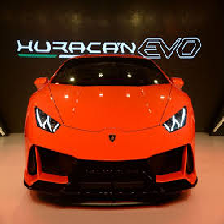

In [19]:
img = image.load_img("../input/cars-dataset/Test/lamborghini/10.jpg", target_size=(224,224))
img

In [20]:
# x=image.img_to_array(img)
x=image.img_to_array(img)
x

array([[[ 17.,   7.,   0.],
        [ 17.,   7.,   0.],
        [ 17.,   7.,   0.],
        ...,
        [ 13.,   2.,   0.],
        [ 14.,   4.,   3.],
        [ 14.,   4.,   3.]],

       [[ 17.,   7.,   0.],
        [ 17.,   7.,   0.],
        [ 18.,   8.,   0.],
        ...,
        [ 14.,   3.,   1.],
        [ 14.,   4.,   3.],
        [ 14.,   4.,   3.]],

       [[ 18.,   8.,   0.],
        [ 18.,   8.,   0.],
        [ 19.,   9.,   0.],
        ...,
        [ 14.,   3.,   1.],
        [ 14.,   4.,   3.],
        [ 14.,   4.,   3.]],

       ...,

       [[209., 129.,  92.],
        [210., 130.,  93.],
        [212., 132.,  95.],
        ...,
        [216., 132.,  96.],
        [214., 129.,  92.],
        [213., 129.,  92.]],

       [[208., 128.,  91.],
        [208., 128.,  91.],
        [211., 131.,  94.],
        ...,
        [215., 131.,  95.],
        [209., 129.,  94.],
        [207., 129.,  93.]],

       [[206., 128.,  90.],
        [206., 128.,  90.],
        [209., 1

In [21]:
x=x/255
x

array([[[0.06666667, 0.02745098, 0.        ],
        [0.06666667, 0.02745098, 0.        ],
        [0.06666667, 0.02745098, 0.        ],
        ...,
        [0.05098039, 0.00784314, 0.        ],
        [0.05490196, 0.01568628, 0.01176471],
        [0.05490196, 0.01568628, 0.01176471]],

       [[0.06666667, 0.02745098, 0.        ],
        [0.06666667, 0.02745098, 0.        ],
        [0.07058824, 0.03137255, 0.        ],
        ...,
        [0.05490196, 0.01176471, 0.00392157],
        [0.05490196, 0.01568628, 0.01176471],
        [0.05490196, 0.01568628, 0.01176471]],

       [[0.07058824, 0.03137255, 0.        ],
        [0.07058824, 0.03137255, 0.        ],
        [0.07450981, 0.03529412, 0.        ],
        ...,
        [0.05490196, 0.01176471, 0.00392157],
        [0.05490196, 0.01568628, 0.01176471],
        [0.05490196, 0.01568628, 0.01176471]],

       ...,

       [[0.81960785, 0.5058824 , 0.36078432],
        [0.8235294 , 0.50980395, 0.3647059 ],
        [0.83137256, 0

In [22]:
x=np.expand_dims(x, axis=0)
x

array([[[[0.06666667, 0.02745098, 0.        ],
         [0.06666667, 0.02745098, 0.        ],
         [0.06666667, 0.02745098, 0.        ],
         ...,
         [0.05098039, 0.00784314, 0.        ],
         [0.05490196, 0.01568628, 0.01176471],
         [0.05490196, 0.01568628, 0.01176471]],

        [[0.06666667, 0.02745098, 0.        ],
         [0.06666667, 0.02745098, 0.        ],
         [0.07058824, 0.03137255, 0.        ],
         ...,
         [0.05490196, 0.01176471, 0.00392157],
         [0.05490196, 0.01568628, 0.01176471],
         [0.05490196, 0.01568628, 0.01176471]],

        [[0.07058824, 0.03137255, 0.        ],
         [0.07058824, 0.03137255, 0.        ],
         [0.07450981, 0.03529412, 0.        ],
         ...,
         [0.05490196, 0.01176471, 0.00392157],
         [0.05490196, 0.01568628, 0.01176471],
         [0.05490196, 0.01568628, 0.01176471]],

        ...,

        [[0.81960785, 0.5058824 , 0.36078432],
         [0.8235294 , 0.50980395, 0.3647059 ]

In [23]:
x.shape

(1, 224, 224, 3)

In [24]:
img_data = preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [25]:
preds = model.predict(x)
print(preds)
preds=np.argmax(preds, axis=1)
preds

1/1 [==============================] - 1s 1s/step
[[1.083641e-06 1.144559e-09 9.999989e-01]]


array([2])

In [26]:
labels = (training_set.class_indices)
print(labels)
type(labels)

{'audi': 0, 'lamborghini': 1, 'mercedes': 2}


dict

In [27]:
labels = dict((v,k) for k,v in labels.items())
print(labels)
# predictions = [labels[k] for k in predicted_class_indices]
type(labels)

{0: 'audi', 1: 'lamborghini', 2: 'mercedes'}


dict

In [28]:
labels[preds[0]].capitalize()

'Mercedes'

In [29]:
img = image.load_img("../input/cars-dataset/Test/audi/25.jpg", target_size=(224,224))
x=image.img_to_array(img)
x=x/255
x=np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
preds = model.predict(x)
preds=np.argmax(preds, axis=1)

print(preds)
labels[preds[0]].capitalize()

1/1 [==============================] - 0s 25ms/step
[2]


'Mercedes'

In [30]:
img = image.load_img("../input/cars-dataset/Test/mercedes/30.jpg", target_size=(224,224))
x=image.img_to_array(img)
x=x/255
x=np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
preds = model.predict(x)

preds=np.argmax(preds, axis=1)
labels[preds[0]].capitalize()

1/1 [==============================] - 0s 25ms/step


'Mercedes'

In [31]:
img = image.load_img("../input/cars-dataset/Test/mercedes/30.jpg", target_size=(224,224))
x=image.img_to_array(img)
x=x/255
x=np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
preds = model.predict(x)

preds=np.argmax(preds, axis=1)
labels[preds[0]].capitalize()

1/1 [==============================] - 0s 24ms/step


'Mercedes'

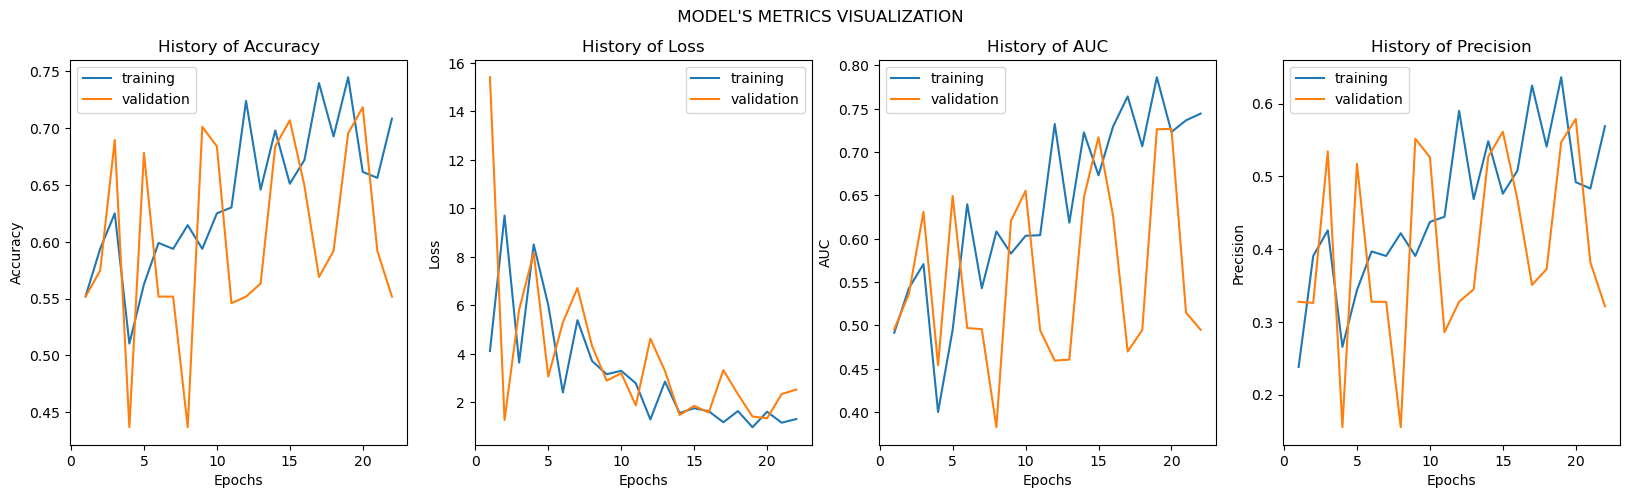

In [32]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision):
    
    fig, (ax1, ax2,ax3,ax4) = plt.subplots(1,4, figsize= (20,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['training', 'validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['training', 'validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['training', 'validation'])


    plt.show()
    

Train_Val_Plot(r.history['accuracy'],r.history['val_accuracy'],
               r.history['loss'],r.history['val_loss'],
               r.history['auc'],r.history['val_auc'],
               r.history['precision'],r.history['val_precision']
              )